In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

GT rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
GT Mode 0: [-5. -5. -5.] +/- [1.  1.5 3.5]
GT Mode 1: [5. 5. 5.] +/- [1.25 0.25 0.25]
GT Mode 2: [-2.  0.  2.] +/- [1.  2.  1.5]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

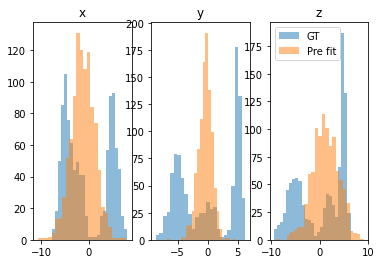

In [2]:
# Make the ground truth GMM grammar.
gt_grammar =SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
# Reset params to values we control (different from prior).
desired_mode_means = [
    torch.tensor([-5., -5., -5.]),
    torch.tensor([5., 5., 5.]),
    torch.tensor([-2., 0., 2.])
]
desired_mode_vars = [
    torch.tensor([1.0, 1.5, 3.5]),
    torch.tensor([1.25, 0.25, 0.25]),
    torch.tensor([1., 2., 1.5])
]
desired_mode_weights = torch.tensor([0.4, 0.4, 0.2])
rule_probs_param = gt_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(desired_mode_weights)
print("GT rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    mean_param.set(desired_mode_means[k])
    var_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    var_param.set(desired_mode_vars[k])
    print("GT Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))

# Make our fitting grammar. This'll also have randomly sampled means + vars, but
# different ones.
torch.random.manual_seed(2)
fit_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
#fit_grammar = deepcopy(gt_grammar)
pre_fit_grammar = deepcopy(fit_grammar)
if 0:
    # Initialize with nicely-separated initial peaks:
    rule_probs_param = pre_fit_grammar.params_by_node_type[Root.__name__]
    print("Pre-fit rule probs: ", rule_probs_param())
    for k, mode in enumerate(Modes):
        mode_name = mode.__name__
        mean_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
        mean_param.set((torch.ones(3)*k - torch.ones(3)) * 3.)
        var_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
        var_param.set(torch.ones(3) * 0.1)
        print("Pre-fit Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))


def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw random samples from our randomly-initialized GMM
def get_draws_from_grammar(grammar, N_samples):
    samples = []
    for k in tqdm(range(N_samples)):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))
    return samples

gt_samples = get_draws_from_grammar(gt_grammar, 1000)
pre_fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_pre_fit = get_all_node_xyzs([sample[0] for sample in pre_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=25, label="GT", alpha=0.5)
    plt.hist(l_pre_fit[:, k], bins=25, label="Pre fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

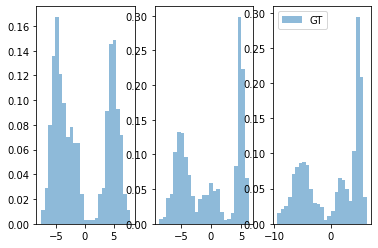

In [3]:
torch.random.manual_seed(43)
N_fit_samples = 100

# Draw an actual fitting dataset.
samples = get_draws_from_grammar(gt_grammar, N_fit_samples)

l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_train[:, k], label="Train", alpha=0.5, bins=25, density=True)
    plt.hist(l_gt[:, k], label="GT", alpha=0.5, bins=25, density=True)
    if k == 2:
        plt.legend()

EM fit rule probs:  tensor([0.4700, 0.1999, 0.3301], grad_fn=<DivBackward0>)
EM-fit Mode 0: Parameter containing:
tensor([4.9814, 5.0070, 5.0496], requires_grad=True) +/- tensor([0.9730, 0.2343, 0.1815], grad_fn=<AddBackward0>)
EM-fit Mode 1: Parameter containing:
tensor([-2.2439, -0.6126,  1.7560], requires_grad=True) +/- tensor([0.8142, 1.5000, 1.1622], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-4.9046, -4.7184, -4.7043], requires_grad=True) +/- tensor([0.7268, 1.8225, 4.4287], grad_fn=<AddBackward0>)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

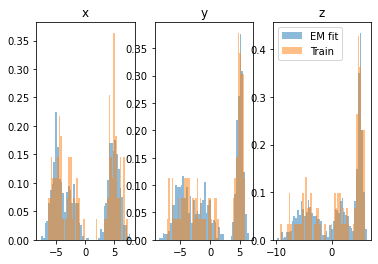

In [4]:
# Hand-written EM baseline for GMM: estimate cluster
# association weights, and then apply a closed form update
# to get new best cluster mean and vars. (Like a "soft"
# k-mean.)

# Initialize param guesses from pre-fit grammar
weights_init = pre_fit_grammar.params_by_node_type[Root.__name__]().detach()
means_init = []
vars_init = []
for mode in Modes:
    mode_name = mode.__name__
    mean = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]().detach()
    var = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]().detach()
    means_init.append(mean)
    vars_init.append(var)
means_init = np.stack(means_init)
vars_init = np.stack(vars_init)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="diag",
    weights_init=pre_fit_grammar.params_by_node_type[Root.__name__]().detach(),
    means_init=means_init,
    precisions_init=1./vars_init
)

X = points = torch.stack([sample[1][0].translation for sample in samples])
gmm.fit(X)

# Make an EM-fit grammar with those params
em_fit_grammar = deepcopy(pre_fit_grammar)
rule_probs_param = em_fit_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(torch.tensor(gmm.weights_))
print("EM fit rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    var_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    mean_param.set(torch.tensor(gmm.means_[k, :]))
    var_param.set(torch.tensor(1./gmm.precisions_[k, :]))
    print("EM-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
# Draw its empirical fit
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
em_fit_samples = get_draws_from_grammar(em_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_em_fit = get_all_node_xyzs([sample[0] for sample in em_fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5, density=True)
    plt.hist(l_em_fit[:, k], bins=50, label="EM fit", alpha=0.5, density=True)
    plt.hist(l_train[:, k], bins=50, label="Train", alpha=0.5, density=True)
    plt.title(label)
    if k == 2:
        plt.legend()

# One-shot parsing with MAP point latent estimates

In [5]:
# Do single-shot fitting of grammar params based on just the optimal parses
one_shot_fit_grammar = deepcopy(pre_fit_grammar)
em = EMWrapper(one_shot_fit_grammar, [sample[1] for sample in samples])
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=3, num_workers=10);

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Final params:  tensor([0.3301, 0.1999, 0.4700])


No handles with labels found to put in legend.
No handles with labels found to put in legend.


GaussianMode_0 :
mean tensor([[-1.3265, -1.2413, -0.1028],
        [ 0.4925,  0.5943,  0.8014],
        [-1.4649, -1.1324, -0.8034],
        [-4.4300, -4.0271, -3.5896],
        [-4.8428, -4.5772, -4.4687],
        [-4.9024, -4.7109, -4.6881],
        [-4.9046, -4.7182, -4.7039],
        [-4.9046, -4.7184, -4.7043],
        [-4.9046, -4.7184, -4.7043],
        [-4.9046, -4.7184, -4.7043],
        [-4.9046, -4.7184, -4.7043]])
0:xyz:mean final: tensor([-4.9046, -4.7184, -4.7043])
variance tensor([[ 9.4140,  1.9705,  7.5793],
        [10.0000, 10.0000, 10.0000],
        [10.0000, 10.0000, 10.0000],
        [ 1.9659,  4.2235, 10.0000],
        [ 0.8401,  2.2875,  5.6416],
        [ 0.7270,  1.8414,  4.5212],
        [ 0.7268,  1.8229,  4.4310],
        [ 0.7268,  1.8225,  4.4288],
        [ 0.7268,  1.8225,  4.4287],
        [ 0.7268,  1.8225,  4.4287],
        [ 0.7268,  1.8225,  4.4287]])
0:xyz:variance final: tensor([0.7268, 1.8225, 4.4287])
GaussianMode_1 :
mean tensor([[-1.2050, -0.1

No handles with labels found to put in legend.


GaussianMode_2 :
mean tensor([[ 0.3923, -0.2236, -0.3195],
        [ 3.6275,  3.9198,  3.7304],
        [ 5.0782,  5.0259,  5.0491],
        [ 4.9834,  5.0070,  5.0495],
        [ 4.9814,  5.0070,  5.0496],
        [ 4.9814,  5.0070,  5.0496],
        [ 4.9814,  5.0070,  5.0496],
        [ 4.9814,  5.0070,  5.0496],
        [ 4.9814,  5.0070,  5.0496],
        [ 4.9814,  5.0070,  5.0496],
        [ 4.9814,  5.0070,  5.0496]])
0:xyz:mean final: tensor([4.9814, 5.0070, 5.0496])
variance tensor([[ 9.1326,  5.2571,  1.2041],
        [10.0000, 10.0000,  5.3512],
        [ 1.0861,  0.3122,  0.2056],
        [ 0.9678,  0.2343,  0.1816],
        [ 0.9730,  0.2343,  0.1815],
        [ 0.9730,  0.2343,  0.1815],
        [ 0.9730,  0.2343,  0.1815],
        [ 0.9730,  0.2343,  0.1815],
        [ 0.9730,  0.2343,  0.1815],
        [ 0.9730,  0.2343,  0.1815],
        [ 0.9730,  0.2343,  0.1815]])
0:xyz:variance final: tensor([0.9730, 0.2343, 0.1815])


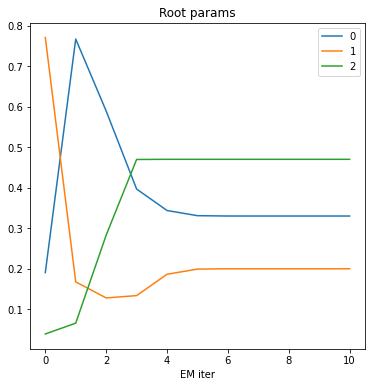

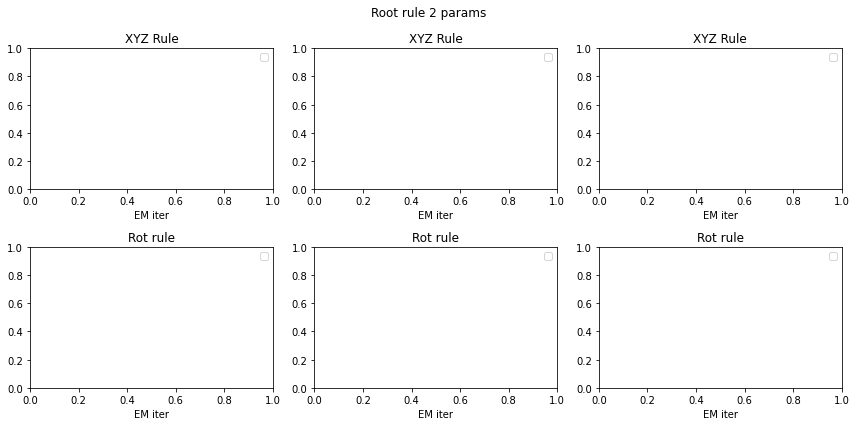

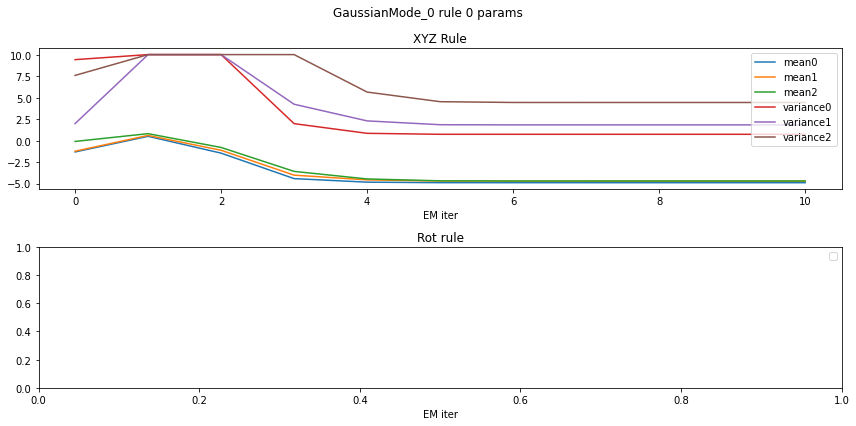

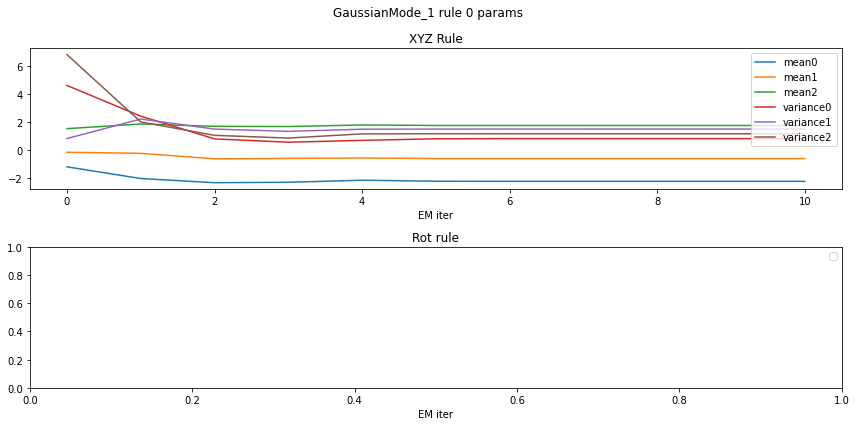

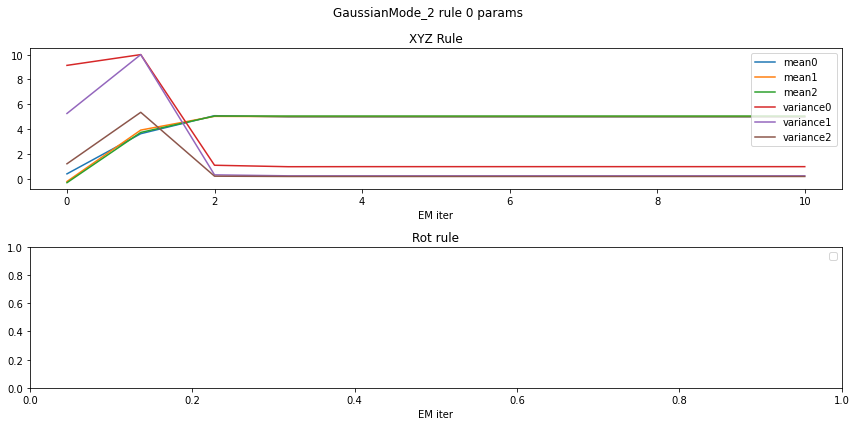

In [6]:
em.plot_grammar_parameter_history(Root)
for mode in Modes:
    print(mode.__name__, ":")
    em.plot_grammar_parameter_history(mode)

  0%|          | 0/1000 [00:00<?, ?it/s]

One shot fit rule probs:  tensor([0.7668, 0.1675, 0.0657], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([0.4925, 0.5943, 0.8014], requires_grad=True) +/- tensor([10.0000, 10.0000, 10.0000], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-2.0421, -0.2373,  1.8629], requires_grad=True) +/- tensor([2.4228, 2.2165, 2.0100], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([3.6275, 3.9198, 3.7304], requires_grad=True) +/- tensor([10.0000, 10.0000,  5.3512], grad_fn=<AddBackward0>)


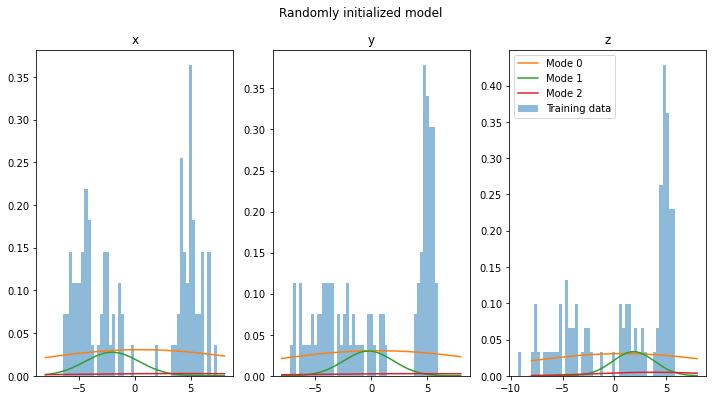

In [7]:
%matplotlib inline
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
def make_figure_for_grammar(one_shot_fit_grammar, axs, N=1000):
    rule_probs_param = one_shot_fit_grammar.params_by_node_type[Root.__name__]
    print("One shot fit rule probs: ", rule_probs_param())
    modes = []
    for k, mode in enumerate(Modes):
        mode_name = mode.__name__
        mean_param = one_shot_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
        var_param = one_shot_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
        modes.append((mean_param(), var_param()))
        print("One shot-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))

    #fit_samples = get_draws_from_grammar(one_shot_fit_grammar, N)
    l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
    #l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
    l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
    xs = np.linspace(-8, 8, 1000)
    for k, label in enumerate("xyz"):
        ax = axs[k]
        ax.hist(l_train[:, k], bins=50, label="Training data", alpha=0.5, density=True)
        #ax.hist(l_gt[:, k], bins=50, label="Test data", alpha=0.5, density=True)
        #plt.hist(l_fit[:, k], bins=50, label="One-shot fit", alpha=0.5, density=True)
        # Plot the mode density
        for mode_k, (prob, mode) in enumerate(zip(rule_probs_param().detach().numpy(), modes)):
            mode = torch.exp(dist.Normal(mode[0][k], mode[1][k]).log_prob(torch.tensor(xs))).detach().numpy() * prob
            ax.plot(xs, mode, label="Mode %d" % mode_k)
        ax.set_title(label)
        if k == 2:
            plt.legend()
            
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 6)
plt.suptitle("Randomly initialized model")

one_shot_fit_grammar.load_state_dict(em.grammar_iters[1])
make_figure_for_grammar(one_shot_fit_grammar, axs)

In [8]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)
fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")

def update(frame):
    one_shot_fit_grammar.load_state_dict(em.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(one_shot_fit_grammar, axs, N=10)
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-8, 8.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

One shot fit rule probs:  tensor([0.1903, 0.7707, 0.0390], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.2050, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([ 0.3923, -0.2236, -0.3195], requires_grad=True) +/- tensor([9.1326, 5.2571, 1.2041], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.1903, 0.7707, 0.0390], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.2050, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter con